In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess

In [2]:
push_updates = True

## Simulate Games to calculate xP

Basic strategy: 

- simulate each shot N times
- sum each of those shots along the columns by event.id, by team
- compare sum by team by simulation
- calculate the probability the team wins the event by comparing % of matches wrt win, lose, draw

In [3]:
# import the shots dataset
shots = pd.read_csv("../datasets/23_24_shotmaps_augmented.csv", index_col='Unnamed: 0')

In [4]:
# pull P(Goal) and match info
sim_df = shots[['xG', 'team', 'opponent', 'event.id']]

In [5]:
# find the number of sample, and the associated weights
N_samples = 100_000
shot_sim_weights = sim_df[['xG']].values

In [6]:
# numeric_columns = [f'Simulation_{i + 1}' for i in range(N_samples)]

In [7]:
# simulate each of the shots
shot_sim_matrix = np.random.binomial(1, shot_sim_weights.squeeze(), size=(N_samples, shot_sim_weights.shape[0]))
shot_sim_matrix.shape

(100000, 1121)

In [8]:
# create column names for the simulated df and concat with match info
simulated_shots_df = pd.DataFrame(shot_sim_matrix.T, columns=[f'Simulation_{i+1}' for i in range(shot_sim_matrix.shape[0])])

simulated_shots_df = pd.concat([simulated_shots_df, shots[['event.id', 'team', 'opponent']]], axis=1)
simulated_shots_df.head()

,Simulation_1,Simulation_2,Simulation_3,Simulation_4,Simulation_5,Simulation_6,Simulation_7,Simulation_8,Simulation_9,Simulation_10,...,Simulation_99994,Simulation_99995,Simulation_99996,Simulation_99997,Simulation_99998,Simulation_99999,Simulation_100000,event.id,team,opponent
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,11352251,Arsenal,Nottingham Forest
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11352251,Nottingham Forest,Arsenal
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11352251,Arsenal,Nottingham Forest
3,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,11352251,Arsenal,Nottingham Forest
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,11352251,Arsenal,Nottingham Forest


In [9]:
# sum each column by event, opponent and team; take the transpose
simulated_events_df = simulated_shots_df.groupby(['event.id', 'team', 'opponent']).sum()
simulated_events_df_t = simulated_events_df.T
simulated_events_df_t.head()

event.id            11352250                          11352251  \
team             Bournemouth West Ham United           Arsenal   
opponent     West Ham United     Bournemouth Nottingham Forest   
Simulation_1               2               2                 3   
Simulation_2               1               1                 2   
Simulation_3               3               2                 2   
Simulation_4               1               1                 3   
Simulation_5               2               1                 4   

event.id                                     11352252                         \
team         Nottingham Forest Brighton & Hove Albion             Luton Town   
opponent               Arsenal             Luton Town Brighton & Hove Albion   
Simulation_1                 0                      5                      2   
Simulation_2                 1                      2                      1   
Simulation_3                 1                      3                      2   
Simulation_4                 2                      5                      0   
Simulation_5                 1                      7                      1   

event.id     11352253                 11352254                   ...  \
team          Everton  Fulham   Crystal Palace Sheffield United  ...   
opponent       Fulham Everton Sheffield United   Crystal Palace  ...   
Simulation_1        3       1                1                0  ...   
Simulation_2        3       2                2                0  ...   
Simulation_3        1       0                2                0  ...   
Simulation_4        1       1                0                0  ...   
Simulation_5        2       0                3                0  ...   

event.id           11352578                   11352584              \
team         Crystal Palace  Wolverhampton Aston Villa   Liverpool   
opponent      Wolverhampton Crystal Palace   Liverpool Aston Villa   
Simulation_1              3              0           3           4   
Simulation_2              4              3           1           4   
Simulation_3              1              0           0           4   
Simulation_4              2              0           1           5   
Simulation_5              3              0           0           2   

event.id            11352590                        11352594                  \
team              Luton Town West Ham United          Fulham Manchester City   
opponent     West Ham United      Luton Town Manchester City          Fulham   
Simulation_1               1               2               1               3   
Simulation_2               1               0               2               4   
Simulation_3               3               1               1               3   
Simulation_4               2               3               1               3   
Simulation_5               0               1               1               2   

event.id             11352597                   
team                  Everton Sheffield United  
opponent     Sheffield United          Everton  
Simulation_1                5                3  
Simulation_2                3                0  
Simulation_3                3                2  
Simulation_4                3                1  
Simulation_5                2                2  

[5 rows x 78 columns]

In [10]:
# calculate possible outcomes for each event
simulated_results = []
for event_id, team, opponent in simulated_events_df_t.columns:
    simulated_results_dict = {'event.id': event_id, 
    # 'slug': f'{team}-{opponent}',
    'team': team,
    'opponent': opponent,
    'results': np.array(simulated_events_df_t[event_id][team][opponent] - simulated_events_df_t[event_id][opponent][team])}

    simulated_results_dict['outcome_code'] = np.where(simulated_results_dict['results'] > 0, 1, -1)
    simulated_results_dict['outcome_code'] = np.where(simulated_results_dict['results'] == 0, 0, simulated_results_dict['outcome_code'])

    simulated_results_dict['win.pct'] = np.average(np.where(simulated_results_dict['outcome_code'] == 1, 1, 0))
    simulated_results_dict['draw.pct'] = np.average(np.where(simulated_results_dict['outcome_code'] == 0, 1, 0))

    simulated_results_dict['xP'] = 3 * simulated_results_dict['win.pct'] + 1 * simulated_results_dict['draw.pct']

    simulated_results.append(simulated_results_dict)

In [11]:
simulated_results_df = pd.DataFrame(simulated_results)
simulated_results_df.head()

,event.id,team,opponent,results,outcome_code,win.pct,draw.pct,xP
0,11352250,Bournemouth,West Ham United,"[0, 0, 1, 0, 1, 0, 3, 1, 1, 3, -1, -2, 1, 2, 4...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, -1, -1, 1, 1, 1...",0.40331,0.31828,1.52821
1,11352250,West Ham United,Bournemouth,"[0, 0, -1, 0, -1, 0, -3, -1, -1, -3, 1, 2, -1,...","[0, 0, -1, 0, -1, 0, -1, -1, -1, -1, 1, 1, -1,...",0.27841,0.31828,1.15351
2,11352251,Arsenal,Nottingham Forest,"[3, 1, 1, 1, 3, 2, 3, 0, 4, 3, 0, 1, 1, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, ...",0.75956,0.17948,2.45816
3,11352251,Nottingham Forest,Arsenal,"[-3, -1, -1, -1, -3, -2, -3, 0, -4, -3, 0, -1,...","[-1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 0, -1,...",0.06096,0.17948,0.36236
4,11352252,Brighton & Hove Albion,Luton Town,"[3, 1, 1, 5, 6, 3, 2, 1, 4, 5, 2, 2, 4, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.92598,0.05732,2.83526


In [12]:
xp_table = pd.DataFrame(simulated_results_df.groupby(by='team')['xP'].sum()).sort_values(by='xP', ascending=False).reset_index()
xp_table.index = range(1, xp_table.shape[0] + 1)
xp_table['xP'] = xp_table['xP'].map('{:,.2f}'.format).astype('float64')
xp_table = xp_table.rename(columns={'team': 'Team'})

In [13]:
xp_table

,Team,xP
1,Manchester City,10.87
2,Arsenal,9.33
3,Tottenham Hotspur,9.25
4,Crystal Palace,7.73
5,Brighton & Hove Albion,7.55
6,West Ham United,7.55
7,Liverpool,7.05
8,Brentford,6.58
9,Chelsea,6.49
10,Aston Villa,5.88


In [14]:
xg_table = pd.read_csv('../assets/xG_table.csv', index_col='Unnamed: 0')

full_table = xg_table.merge(xp_table, how='outer', left_on='Team', right_on='Team')
full_table = full_table.sort_values(by='xP', ascending=False, inplace=False)
full_table.index = range(1, full_table.shape[0] + 1)

In [15]:
full_table.to_csv('../assets/full_table.csv')
full_table.to_markdown('../assets/full_table.md')
full_table

,Team,xG,xGA,xG Differential,xP
1,Manchester City,10.554,2.331,8.223,10.87
2,Arsenal,8.231,3.337,4.893,9.33
3,Tottenham Hotspur,10.405,5.023,5.382,9.25
4,Crystal Palace,6.063,2.627,3.436,7.73
5,Brighton & Hove Albion,9.638,6.411,3.227,7.55
6,West Ham United,8.264,5.394,2.871,7.55
7,Liverpool,8.190,5.419,2.772,7.05
8,Brentford,7.941,5.425,2.517,6.58
9,Chelsea,6.414,4.537,1.877,6.49
10,Aston Villa,7.865,8.311,-0.446,5.88


In [16]:
if push_updates:
    subprocess.run(["/Users/harrisonward/Desktop/CS/Git/xG/scripts/update_on_github.sh"])
    subprocess.run(["/Users/harrisonward/Desktop/CS/Git/xG/scripts/push_assets.sh"])

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
	modified:   assets/full_table.csv
	modified:   assets/full_table.md
	modified:   models/xG_model.ipynb
	modified:   models/xP_model.ipynb
	modified:   scripts/.DS_Store
	modified:   scripts/__pycache__/event_scraper.cpython-39.pyc
	modified:   scripts/__pycache__/shotmap_extractor.cpython-39.pyc
	modified:   scripts/logs/updater.log
	deleted:    scripts/scripts/__pycache__/event_scraper.cpython-39.pyc
	deleted:    scripts/scripts/__pycache__/shotmap_extractor.cpython-39.pyc
	deleted:    scripts/scripts/event_scraper.py
	deleted:    scripts/scripts/logs/updater.log
	deleted:    scripts/scripts/shotmap_extractor.py
	deleted:    scripts/scripts/update_on_github.sh
	deleted:    scripts/scripts/updater.py

Untracked files:
	datasets/23_24_shotmaps_augmented.csv
	scripts/event_scraper.py
	scripts/push_assets.sh
	scripts/shotmap_extractor.py
	scripts/update_on_github.sh
	scripts/updater.py

no change

Everything up-to-date


[main 468f8e4] Auto-commit all assets
 2 files changed, 33 insertions(+), 33 deletions(-)
 rewrite assets/full_table.csv (60%)


To https://github.com/Harrison-Ward/xG.git
   bc98c5e..468f8e4  main -> main


## Visualize select outcomes

In [24]:
def addlabels(x,y, vertical_bob):
    for i in range(len(x)):
        plt.text(i, y[i] + vertical_bob, f'{y[i]:.2f}', ha = 'center')

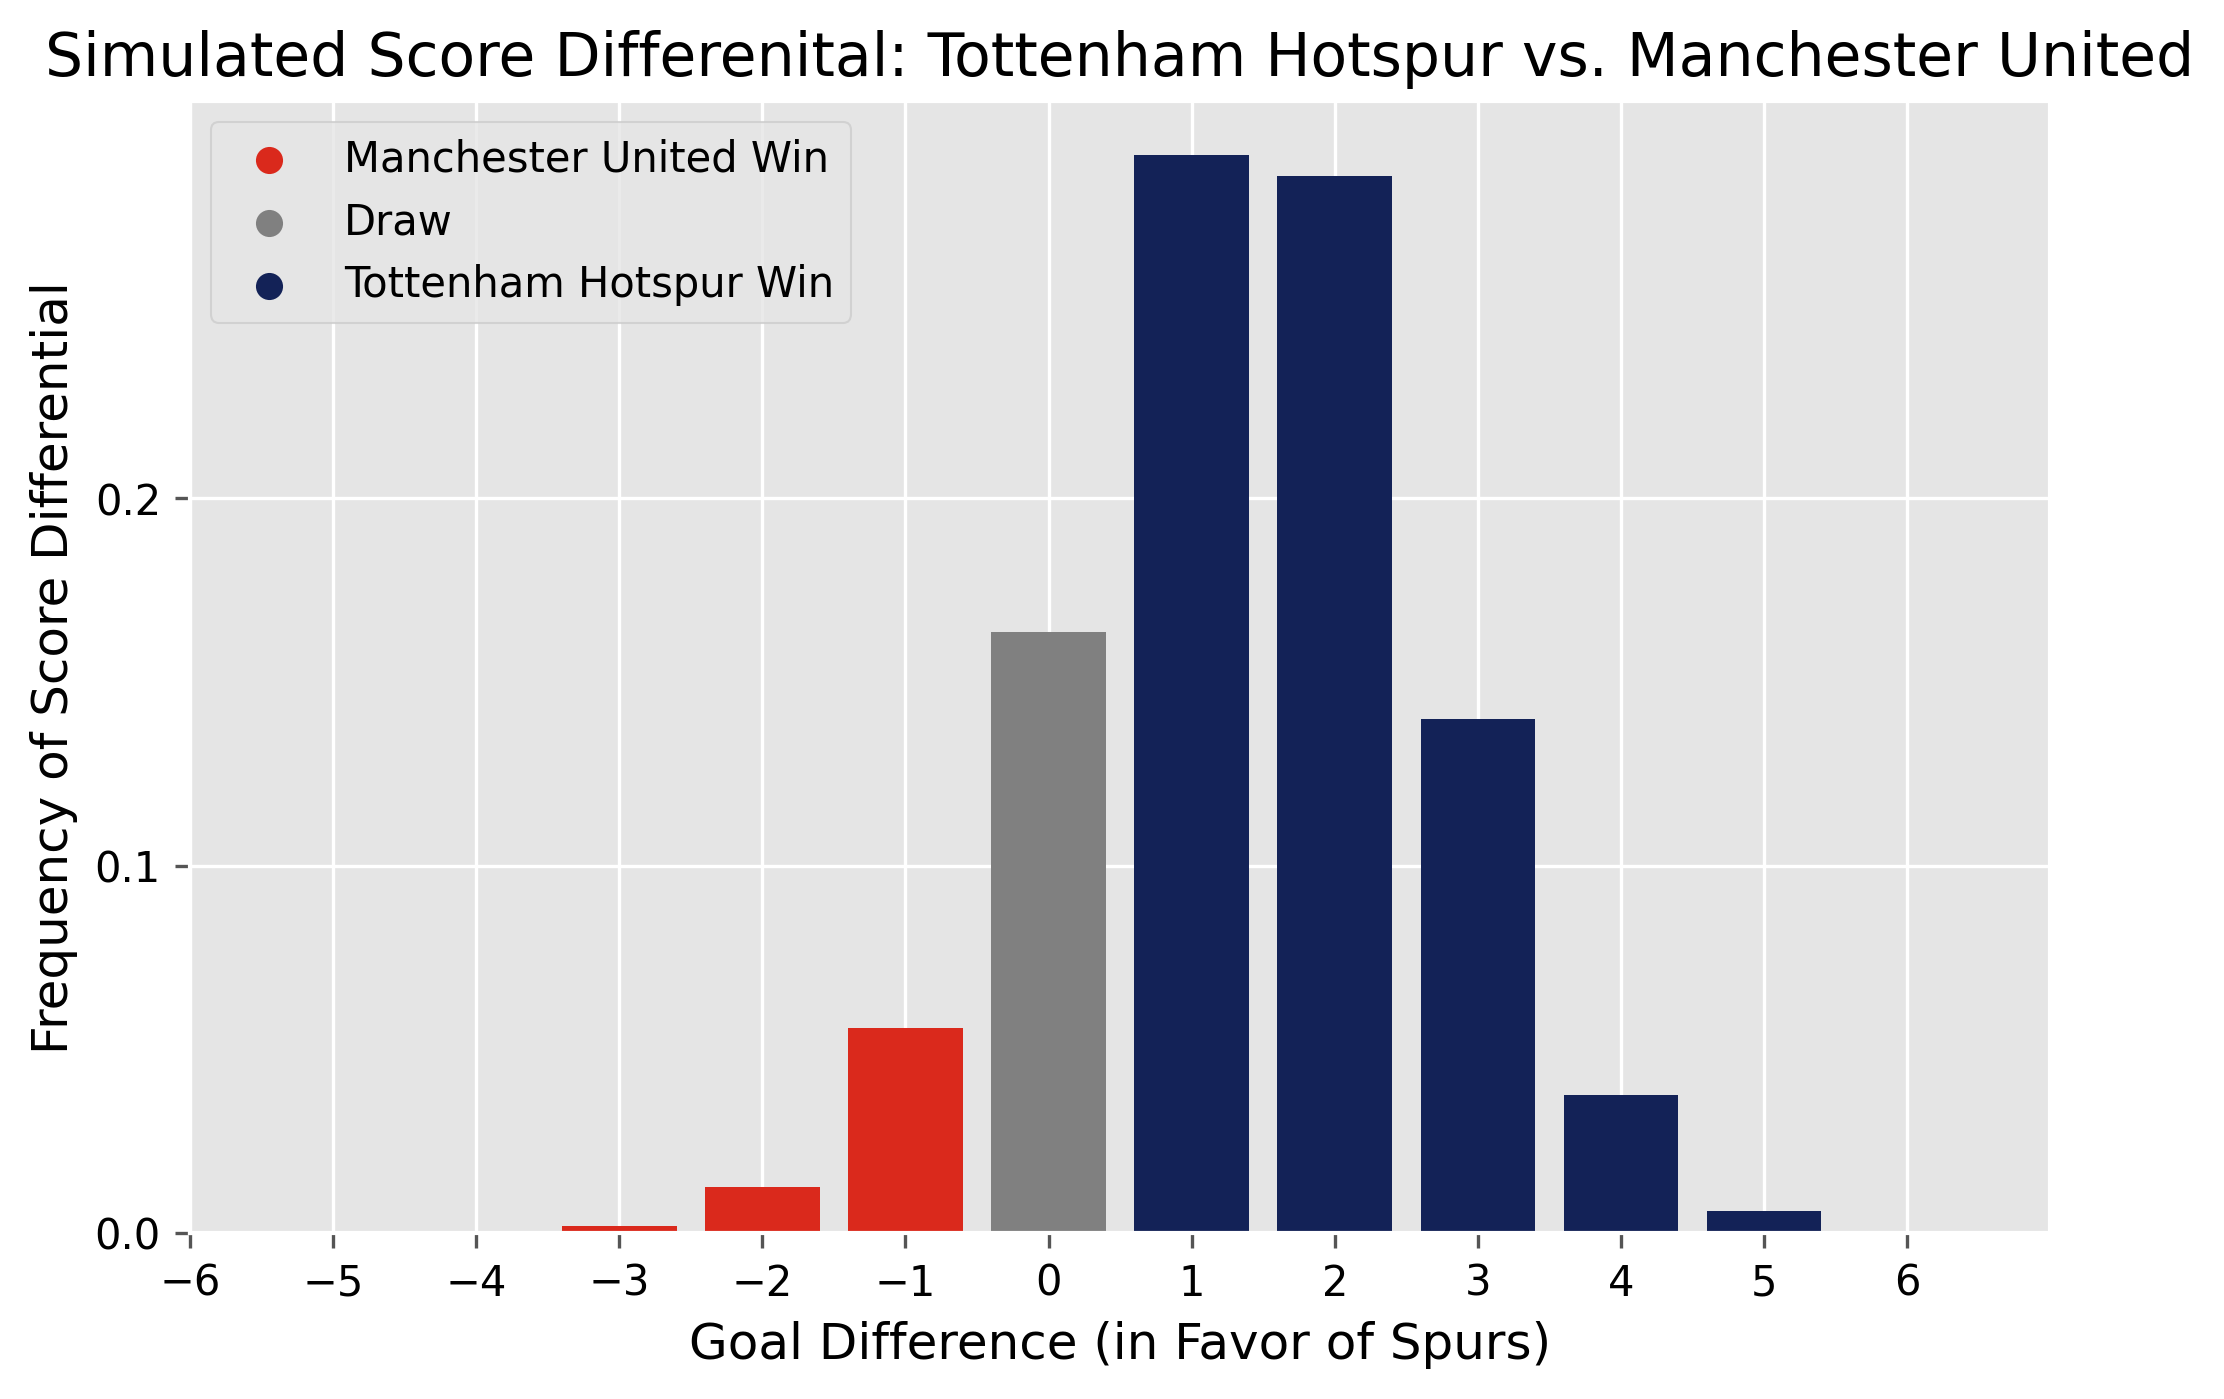

In [38]:
tot_man_scores = simulated_results_df.results[(simulated_results_df['team'].astype(str) == "Tottenham Hotspur") & (simulated_results_df['opponent'].astype(str) == 'Manchester United')].values[0].astype(float)


values, counts = np.unique(tot_man_scores, return_counts=True)
frequencies = counts /np.sum(counts)
x_bound = max(np.abs(values))
colors = np.where(values > 0, '#132257', '#DA291C')
colors = np.where(values == 0, 'grey', colors)

plt.figure(figsize = (8,5), dpi=300)
plt.style.use('ggplot')
plt.tick_params(left = True, right = False , labelleft = True ,
                labelbottom = True, bottom = True)
plt.bar(values, frequencies, color=colors)
plt.scatter(None, None, color='#DA291C', label='Manchester United Win')
plt.scatter(None, None, color='grey', label='Draw')
plt.scatter(None, None, color='#132257', label='Tottenham Hotspur Win')
plt.title('Simulated Score Differenital: Tottenham Hotspur vs. Manchester United')
plt.xlabel('Goal Difference (in Favor of Spurs)', color='Black')
plt.ylabel('Frequency of Score Differential', color='Black')
plt.xticks(np.arange(-x_bound, x_bound), color='Black')
plt.yticks(np.arange(0, np.max(frequencies), step=0.1), color='Black')
plt.xlim(-x_bound + 1, x_bound)
plt.legend()
plt.show()


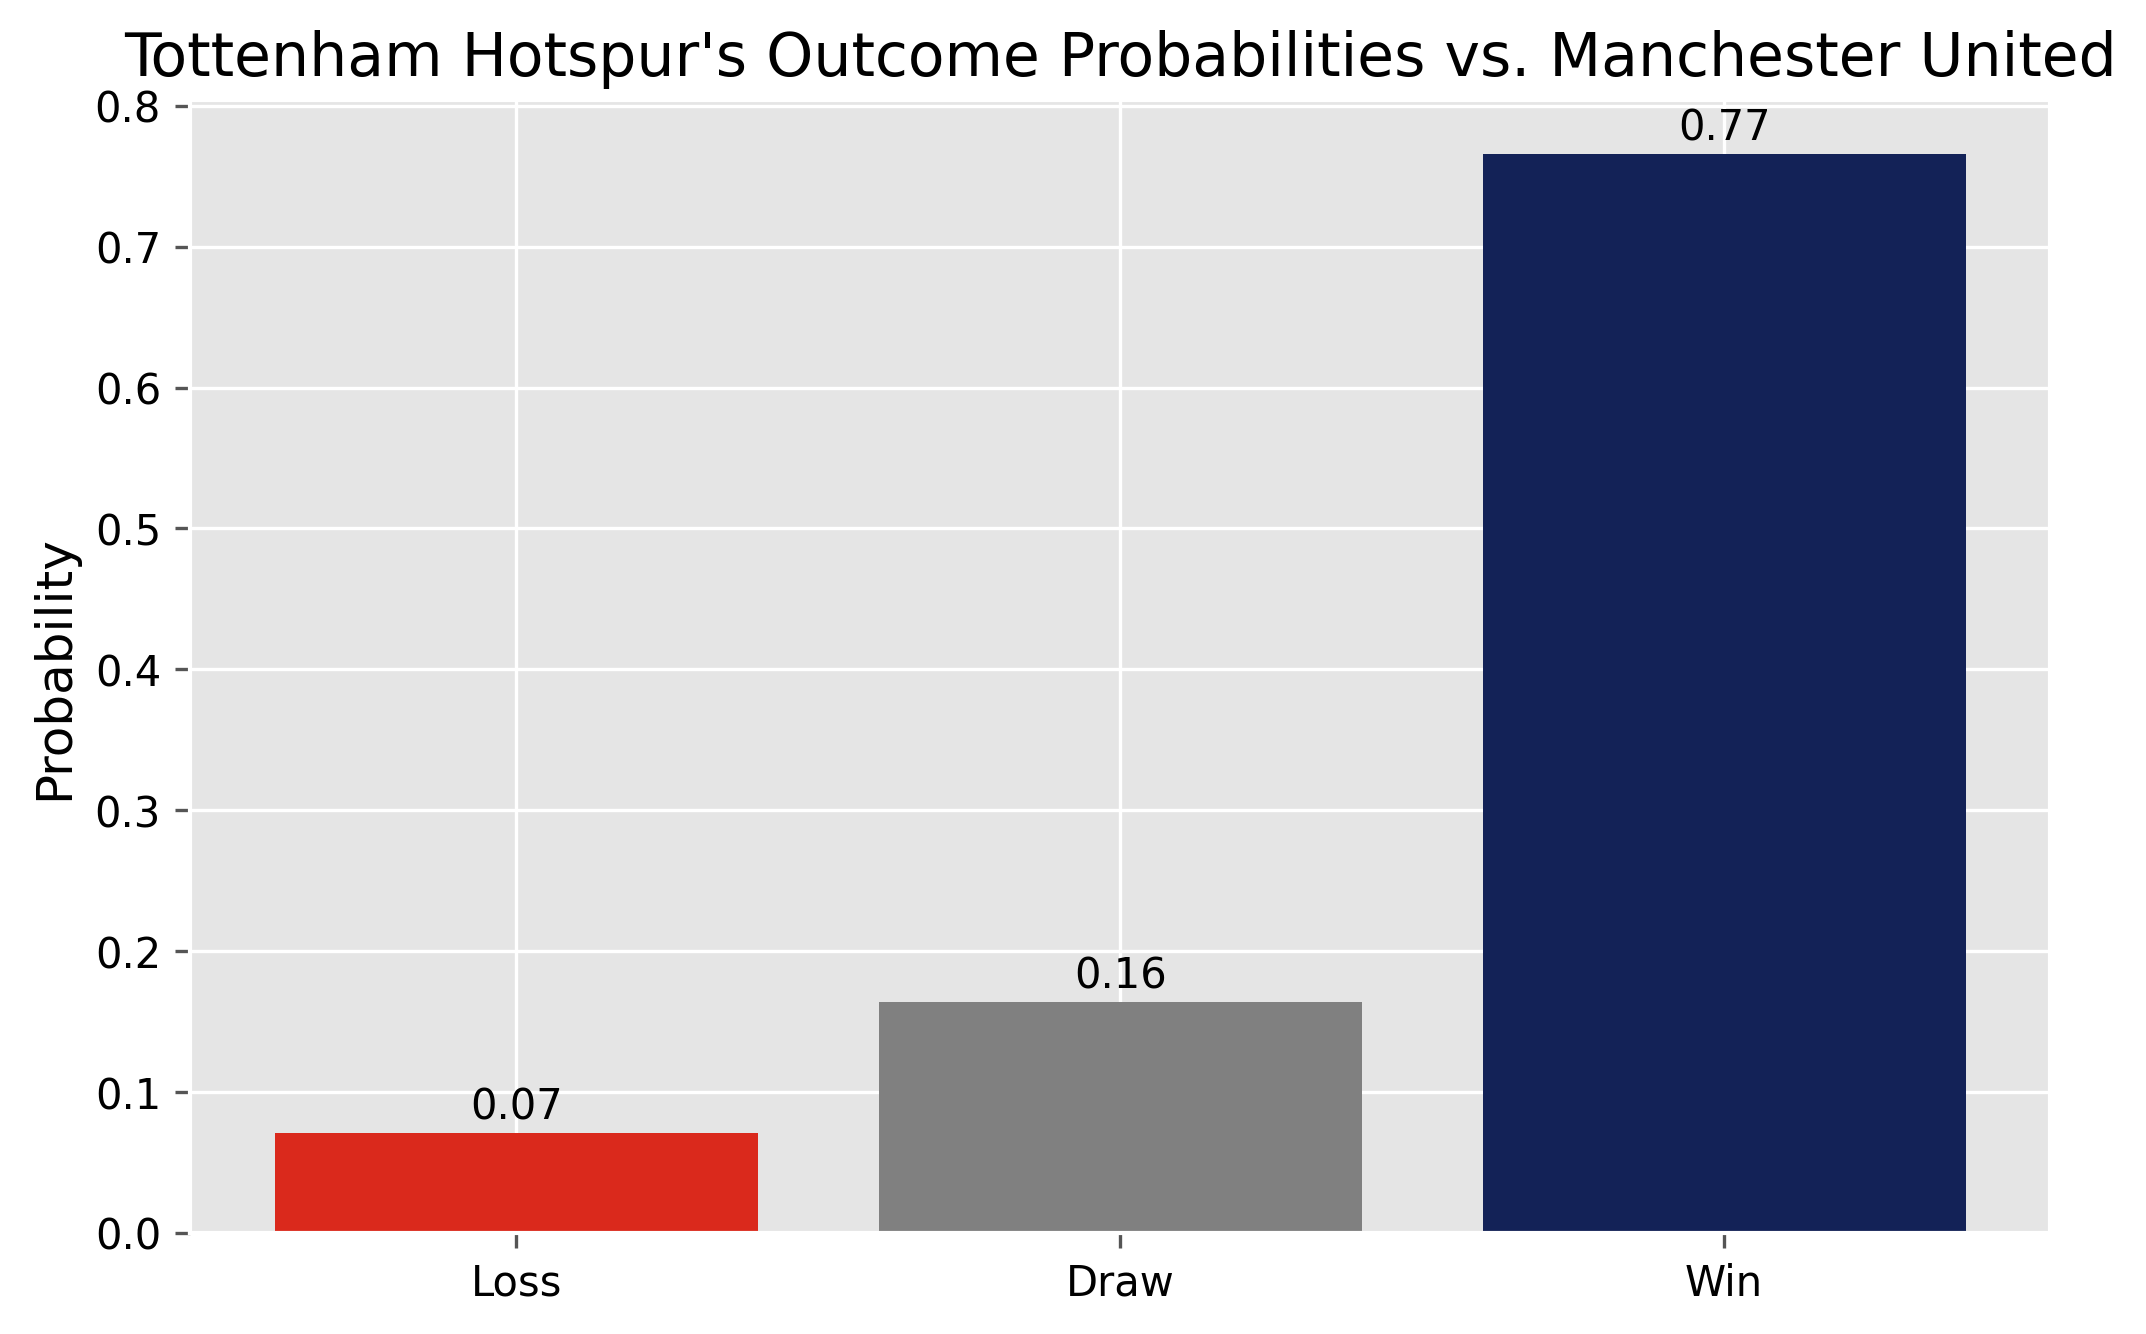

In [37]:
outcome_probablities = simulated_results_df[['win.pct', 'draw.pct']][(simulated_results_df['team'].astype(str) == "Tottenham Hotspur") & (simulated_results_df['opponent'].astype(str) == 'Manchester United')].values
outcome_probablities = np.append(outcome_probablities, 1 - np.sum(outcome_probablities))
outcome_probablities = outcome_probablities[::-1]

colors = ['#DA291C', 'grey', '#132257']

plt.figure(figsize = (8,5), dpi=300)
plt.style.use('ggplot')
x_axis = np.arange(outcome_probablities.shape[0])
plt.title('Tottenham Hotspur\'s Outcome Probabilities vs. Manchester United')
plt.bar(x_axis, outcome_probablities, color=colors)
addlabels(x_axis, outcome_probablities, 0.01)
plt.xticks(np.arange(outcome_probablities.shape[0]), labels=['Loss', 'Draw', 'Win'], color='black')
plt.yticks(color='black')
plt.ylabel('Probability', color='black')
plt.show()

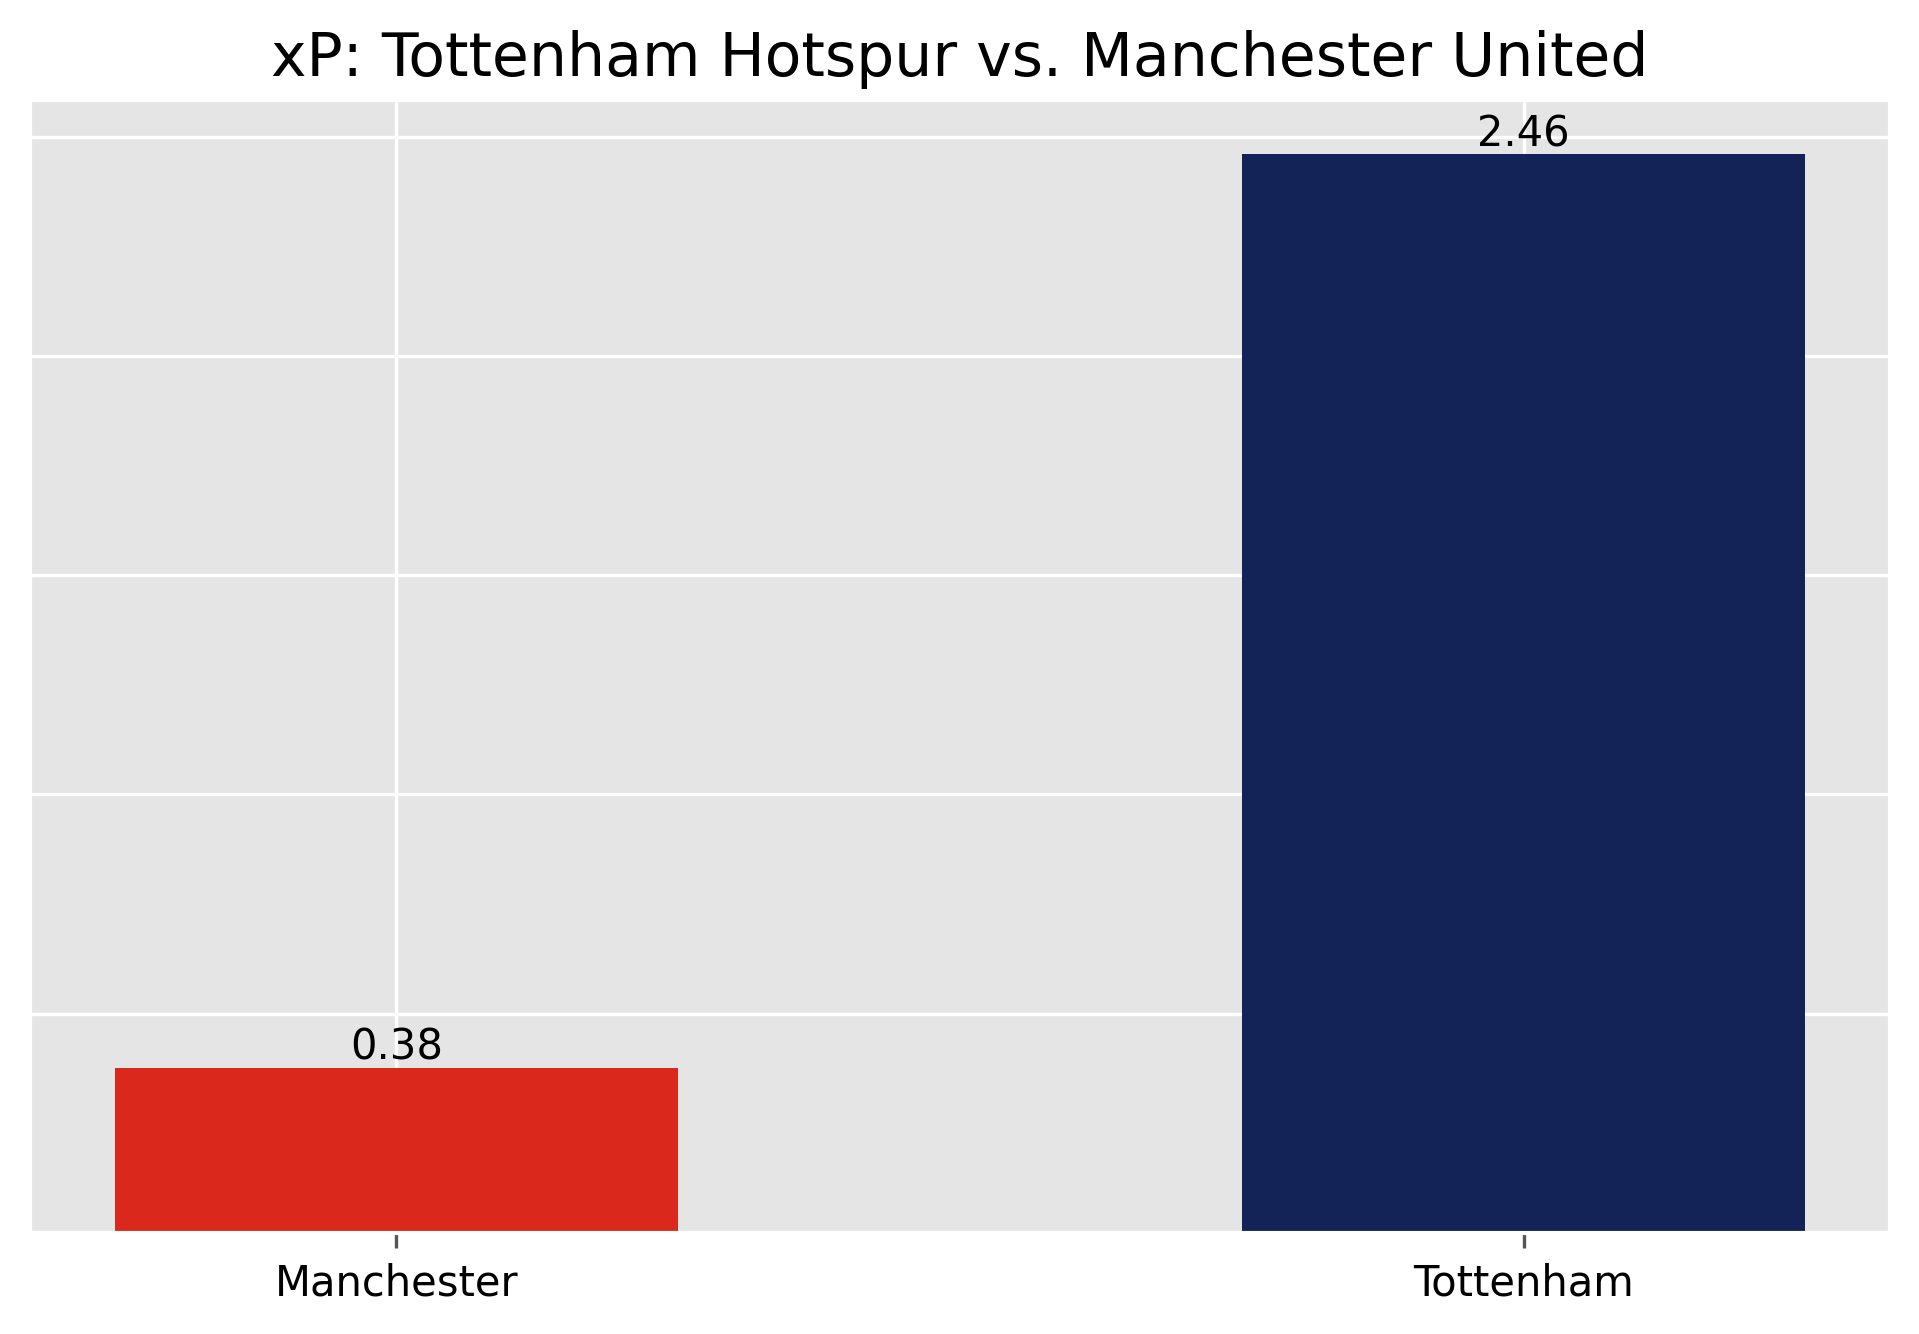

In [36]:
tot_xp = 3 * outcome_probablities[2] + 1 * outcome_probablities[1]
man_xp = 3 * outcome_probablities[0] + 1 * outcome_probablities[1]

colors = ['#DA291C','#132257']
plt.figure(figsize = (8,5), dpi=300)
plt.style.use('ggplot')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)
plt.bar([0,1], [man_xp, tot_xp], color = colors, width=0.5)
addlabels([0,1], [man_xp, tot_xp], 0.02)
plt.title('xP: Tottenham Hotspur vs. Manchester United')
plt.xticks([0,1], ['Manchester', 'Tottenham'], color='Black')
plt.yticks(color='black')

plt.show()